In [1]:
%load_ext autoreload
%autoreload 2

import io
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from scipy.stats import spearmanr
import sqlite3
import torch
from tqdm import tqdm

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations, utils, similarity_utils

/n/fs/ac-project/anaconda3/envs/vlm-lens-base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# TODO: Update config file
# Qwen2-VL-2B-Instruct Attention Values
# config_path = '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualBlocks_AttnValues.yaml'
# Qwen2-VL-7B-Instruct Attention Values
# config_path = '../configs/models/qwen/Qwen2-VL-7B-Instruct-VisualBlocks_AttnValues.yaml'
# LLaVA-1.5-7B Attention Values
config_path = '../configs/models/llava/LLaVA-1.5-7B-VisualBlocks_AttnValues.yaml'

sys.argv = ['notebooks/track_mean_sims_across_layers.ipynb',
            '--config', config_path]

config = Config()
model = get_model(config.architecture, config)
utils.informal_log("Using {}".format(config.get_model_id()))
utils.informal_log("Data from: {}".format(config.input_dir))
# Print # parameters and model architecture
utils.informal_log("{:.3f}B parameters".format(model.model.num_parameters() / 1e9))
utils.informal_log(model.model)

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 12.11it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


[1024_100642] Using llava-1.5-7b-hf
[1024_100642] Data from: ../data_local/coco/cocoval_50.txt
[1024_100642] 7.063B parameters
[1024_100642] LlavaForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
 

In [3]:
n_modules = 0
layer_names = []
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)
        layer_names.append(name)
        n_modules += 1
utils.informal_log("{} modules matched".format(n_modules))

vision_tower.vision_model.encoder.layers.0.self_attn.v_proj
vision_tower.vision_model.encoder.layers.1.self_attn.v_proj
vision_tower.vision_model.encoder.layers.2.self_attn.v_proj
vision_tower.vision_model.encoder.layers.3.self_attn.v_proj
vision_tower.vision_model.encoder.layers.4.self_attn.v_proj
vision_tower.vision_model.encoder.layers.5.self_attn.v_proj
vision_tower.vision_model.encoder.layers.6.self_attn.v_proj
vision_tower.vision_model.encoder.layers.7.self_attn.v_proj
vision_tower.vision_model.encoder.layers.8.self_attn.v_proj
vision_tower.vision_model.encoder.layers.9.self_attn.v_proj
vision_tower.vision_model.encoder.layers.10.self_attn.v_proj
vision_tower.vision_model.encoder.layers.11.self_attn.v_proj
vision_tower.vision_model.encoder.layers.12.self_attn.v_proj
vision_tower.vision_model.encoder.layers.13.self_attn.v_proj
vision_tower.vision_model.encoder.layers.14.self_attn.v_proj
vision_tower.vision_model.encoder.layers.15.self_attn.v_proj
vision_tower.vision_model.encoder.

In [65]:
db_path = model.config.output_db
utils.informal_log("Database path: {}".format(db_path))
proceed = True
if os.path.exists(db_path):
    response = input("File exists at {}. Are you sure you want to overwrite? (Y/N)".format(db_path))
    if response.lower() != "y":
        proceed = False
    else:
        os.remove(db_path)

if proceed:
    # Run model on images
    model.run(save_tokens=True)
else:
    utils.informal_log("Not overwriting file at {}".format(db_path))

[1023_102903] Database path: ../output/LLaVA-1.5-7B/AttentionValues.db


Running forward hooks on data: 100%|██████████| 50/50 [32:22<00:00, 38.86s/it]


In [4]:
db_path = model.config.output_db
utils.informal_log(db_path)
connection = sqlite3.connect(db_path)
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

# for r in cursor.execute("""
#   SELECT layer, tensor
#   FROM tensors
#   LIMIT 20
# """):
#     tensor_bytes = r['tensor']
#     tensor = torch.load(io.BytesIO(tensor_bytes), map_location='cpu', weights_only=False)

#     print(r['layer'], tensor.shape)

# connection.close()

[1024_100657] ../output/LLaVA-1.5-7B/AttentionValues.db


In [18]:
# Compute image-pair similarities per layer
print(os.path.splitext(db_path)[0])
db_dir = os.path.splitext(db_path)[0]
module_names, module_embeddings, module_similarities = similarity_utils.compute_image_pair_similarities(
    database_path=db_dir,
    model=model,
    layer_names=layer_names,
    modalities=['vision', "text+vision"],
    attn_component="value")



../output/LLaVA-1.5-7B/AttentionValues


100%|██████████| 58/58 [02:05<00:00,  2.16s/it]


In [21]:
# print(module_names)
# for e in module_embeddings:
#     print(e.shape)

# for s in module_similarities:
#     print(s.shape)

print(module_names[-5:])
print(module_similarities[-1][:5])
print(module_similarities[-2][:5])

['language_model.model.layers.30.self_attn.v_proj', 'language_model.model.layers.31.self_attn.v_proj-vision', 'language_model.model.layers.31.self_attn.v_proj', 'language_model.model.norm-vision', 'language_model.model.norm']
[0.88388114 0.93201661 0.89549241 0.86790926 0.90855264]
[0.8826382  0.93169669 0.89474324 0.8671228  0.90781291]


dict_keys(['vision_tower', 'multi_modal_projector', 'language_model (vision)', 'language_model'])


<Figure size 640x480 with 0 Axes>

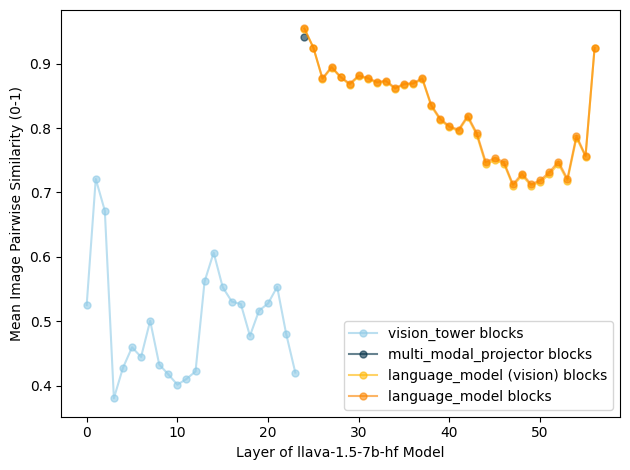

In [19]:
# Computer mean similarity at each layer (using vision or vision + text)
# and plot

mean_embeddings, mean_similarities = similarity_utils.plot_similarities(
    module_names=module_names,
    module_embeddings=module_embeddings,
    module_similarities=module_similarities,
    vision_key=model.get_vision_key(),
    model_name=model.config.get_model_id())